In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pylab import *
import struct
import array
import os
from scipy.interpolate import griddata

# Athena++ modules
# import athena_read
import athena_read_select
import h5py
import netCDF4
import xarray as xr

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
filename = 'disk.out1.00100.athdf'

In [3]:
q = 0.9e-3
Rh = (q/3) ** (1/3)

In [4]:
leveln = None
quantities=['rho','press','vel1','vel2','vel3']
with h5py.File(filename, 'r') as f:
      attributes = f.attrs.items()
      attrs = dict(attributes)
      level = f.attrs['MaxLevel']
      time = f.attrs['Time']

subsample = False
if leveln is not None:
    if level > leveln:
        subsample = True
    level = leveln
data = athena_read_select.athdf(filename, quantities=quantities,
    level=level, subsample=subsample)

b'spherical_polar'
[b'prim']
4
[24 24 24]
1480314
2772
[5]
[168  72 576]
[0.4      2.5      1.003814]
[1.3962634 1.7453293 1.       ]
[0.        6.2831855 1.       ]
628.31854
[b'rho' b'press' b'vel1' b'vel2' b'vel3']


In [5]:
data['rho'].shape

(588, 1152, 560)

In [6]:
data['x1v']

array([0.86706686, 0.8677359 , 0.8684053 , 0.8690747 , 0.8697442 ,
       0.8704138 , 0.8710837 , 0.8717537 , 0.8724239 , 0.8730943 ,
       0.8737649 , 0.8744354 , 0.87510616, 0.8757772 , 0.87644833,
       0.8771196 , 0.87779117, 0.87846285, 0.87913454, 0.87980634,
       0.8804785 , 0.8811507 , 0.8818231 , 0.8824958 , 0.88316864,
       0.88384145, 0.8845144 , 0.8851876 , 0.88586104, 0.8865346 ,
       0.88720834, 0.8878823 , 0.8885562 , 0.88923043, 0.88990474,
       0.8905792 , 0.891254  , 0.8919288 , 0.8926037 , 0.8932789 ,
       0.8939543 , 0.8946297 , 0.89530534, 0.8959811 , 0.89665693,
       0.89733297, 0.8980093 , 0.89868575, 0.8993623 , 0.9000391 ,
       0.90071595, 0.90139306, 0.90207034, 0.9027478 , 0.9034254 ,
       0.9041031 , 0.9047809 , 0.9054589 , 0.90613717, 0.9068155 ,
       0.90749395, 0.90817267, 0.9088516 , 0.9095306 , 0.9102097 ,
       0.9108891 , 0.9115686 , 0.91224825, 0.9129281 , 0.913608  ,
       0.91428804, 0.9149683 , 0.9156488 , 0.91632944, 0.91701

In [7]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['black','cyan','magenta'])

In [8]:
thetapos=np.abs(data['x2v']-0.5*np.pi).argmin()
phipos=400

In [9]:
data['x3v'].shape

(588,)

In [10]:
xp = -1-Rh
yp = -Rh
zp = -Rh

In [11]:
x = data['x1v'][np.newaxis, np.newaxis,:] * np.sin(data['x2v'][np.newaxis, :, np.newaxis]) * np.cos(data['x3v'][:,np.newaxis, np.newaxis])
y = data['x1v'][np.newaxis, np.newaxis,:] * np.sin(data['x2v'][np.newaxis, :, np.newaxis]) * np.sin(data['x3v'][:,np.newaxis, np.newaxis])
z = data['x1v'][np.newaxis, np.newaxis,:] * np.cos(data['x2v'][np.newaxis, :, np.newaxis])

In [12]:
x.shape

(588, 1152, 560)

In [13]:
dist = np.sqrt((x - xp) ** 2 + (y - yp) ** 2 + (z - zp) ** 2)

In [14]:
dist.shape

(588, 1152, 560)

In [15]:
vx = data['vel1'] * np.sin(data['x2v'][np.newaxis, :, np.newaxis]) * np.cos(data['x3v'][:,np.newaxis, np.newaxis]) 
+ data['vel2'] * np.cos(data['x2v'][np.newaxis, :, np.newaxis]) * np.cos(data['x3v'][:,np.newaxis, np.newaxis]) 
- data['vel3'] * np.sin(data['x3v'][:,np.newaxis, np.newaxis])

vy = data['vel1'] * np.sin(data['x2v'][np.newaxis, :, np.newaxis]) * np.sin(data['x3v'][:,np.newaxis, np.newaxis]) 
+ data['vel2'] * np.cos(data['x2v'][np.newaxis, :, np.newaxis]) * np.sin(data['x3v'][:,np.newaxis, np.newaxis]) 
+ data['vel3'] * np.cos(data['x3v'][:,np.newaxis, np.newaxis])

vz = data['vel1'] * np.cos(data['x2v'][np.newaxis, :, np.newaxis]) - data['vel2'] * np.sin(data['x2v'][np.newaxis, :, np.newaxis])

Lz = data['rho'] * (vy * x - vx * y)
Ly = data['rho'] * (vz * x - vx * z)
Lx = data['rho'] * (vz * y - vy * z)
Flux_L = (Lz * vx * (x - xp) 
                + Lz * vy * (y - yp) 
                + Lz * vz * (z - zp)) / dist

In [16]:
Lz/(4*np.pi/Rh)

array([[[ 0.0000000e+00, -3.3124653e-17, -3.3124653e-17, ...,
          0.0000000e+00,  0.0000000e+00, -3.3630871e-16],
        [ 0.0000000e+00,  0.0000000e+00, -3.3124653e-17, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  3.3124653e-17,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        ...,
        [ 0.0000000e+00, -2.5987644e-17,  0.0000000e+00, ...,
         -3.6519100e-16, -3.6519100e-16,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 2.9185662e-17,  0.0000000e+00,  2.5987644e-17, ...,
          7.3038200e-16,  3.6519100e-16,  3.6519100e-16]],

       [[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  3.3630871e-16, -3.3630871e-16],
        [ 0.0000000e+00,  3.3124653e-17,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  3.3630871e-16],
        [ 0.0000000e+00, 

In [91]:
norm_Flux_l = Flux_L / ((-data['rho'] * data['vel1'] * vx * (x - xp) 
                + -data['rho'] * data['vel1'] * vy * (y - yp) 
                + -data['rho'] * data['vel1'] * vz * (z - zp)) / dist)

/var/folders/6b/q0ls5s7570d8s04fbvw5gmxw0000gn/T/ipykernel_92180/3121004661.py:1: RuntimeWarning: divide by zero encountered in divide
  norm_Flux_l = Flux_L / ((-data['rho'] * data['vel1'] * vx * (x - xp)
/var/folders/6b/q0ls5s7570d8s04fbvw5gmxw0000gn/T/ipykernel_92180/3121004661.py:1: RuntimeWarning: invalid value encountered in divide
  norm_Flux_l = Flux_L / ((-data['rho'] * data['vel1'] * vx * (x - xp)


In [80]:
Flux_L

array([[[ 0.00000000e+00,  1.07915364e-17,  1.06316937e-17, ...,
          0.00000000e+00,  0.00000000e+00, -2.34215065e-16],
        [ 0.00000000e+00,  0.00000000e+00,  1.08192792e-17, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00, -1.10785565e-17,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 0.00000000e+00, -2.08901320e-17,  0.00000000e+00, ...,
         -6.69057825e-16, -6.67046705e-16,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 3.05425622e-17,  0.00000000e+00,  2.10930610e-17, ...,
          1.34144354e-15,  6.68714036e-16,  6.66709268e-16]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  2.36507613e-16, -2.34817121e-16],
        [ 0.00000000e+00, -1.10126418e-17,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e

In [93]:
norm_Flux_l.shape

(588, 1152, 560)

In [42]:
theta_surf = np.arccos((z-zp)/dist)
phi_surf = np.arctan2((y-yp), (x-xp))
# L_tot_surf = np.dot(L_tot_vec, r_rel_vec.T) / r_surf**2


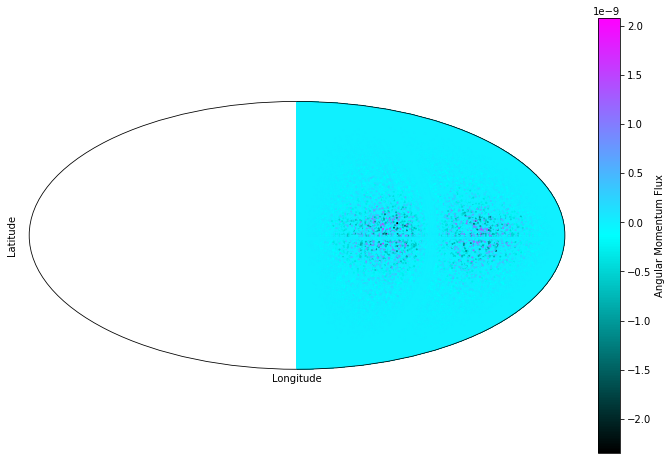

In [44]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='mollweide')
lon = np.pi - phi_surf
lat = np.pi/2 - theta_surf
cax = ax.scatter(lon, lat, c=Flux_L, s=1, cmap=cmap)
# ax.grid(True)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_yticklabels([])
ax.set_xticklabels([])
cbar = fig.colorbar(cax, orientation='vertical')
cbar.set_label('Angular Momentum Flux')
plt.show()

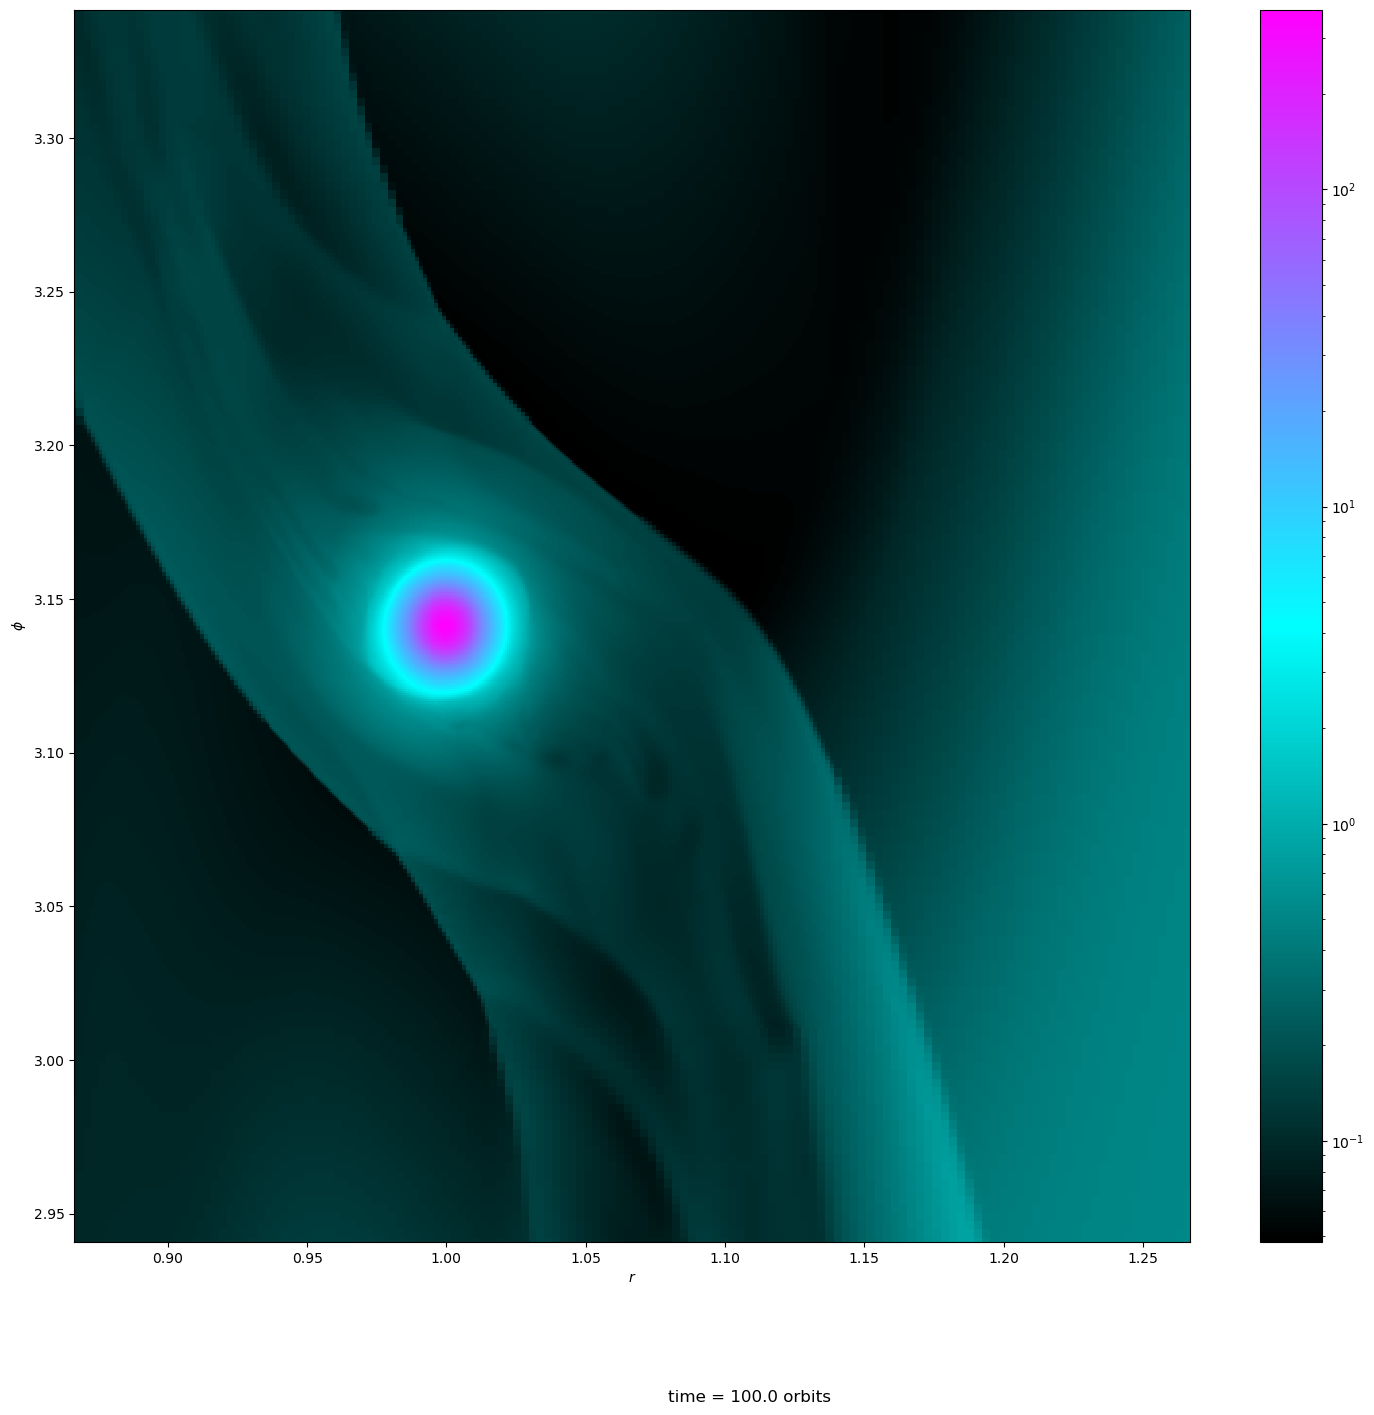

In [15]:
plots, axes = plt.subplots(figsize=(18,16))

plt.ylabel('$\\phi$')
plt.xlabel('$ r$')
minval=min(data['rho'][:,thetapos,:][0])
maxval=max(data['rho'][:,thetapos,:][0])
ridx = np.where(data['x1f'])[0][:-1]
phiidx = np.where(data['x3f'])[0][:-1]

norm=matplotlib.colors.LogNorm()
xmesh,zmesh=np.meshgrid(data['x1f'][ridx],data['x3f'][phiidx])
im=axes.pcolormesh(xmesh,zmesh,data['rho'][:,thetapos,:][phiidx][:,ridx],cmap=cmap, norm=norm)     

cbar=plots.colorbar(im, ax=axes)

ratex = 40
ratez = 12

U = data['vel1'][:,thetapos,:].T[::ratex][:,::ratez]
V = data['vel3'][:,thetapos,:].T[::ratex][:,::ratez]

x = np.linspace(data['x1f'][0], data['x1f'][-1], U.shape[0])#[::ratex]
z = np.linspace(data['x3f'][0], data['x3f'][-1], U.shape[1])#[::ratez]

X,Z = np.meshgrid(z,x)

#  Varying density along a streamline
# plt.streamplot(X,Z, U, V, color = 'indigo')


plt.figtext(0.5, 0.01, 'time = '+str(data['Time'] // (2*np.pi)) + ' orbits', ha="center", fontsize=12)
# plt.title('Zoomed-in density, r and theta')
axes.set_aspect('auto')
#plt.style.use('dark_background')
plt.show()

In [16]:
data['rho'][:,thetapos,:][:,ridx].shape

(588, 560)

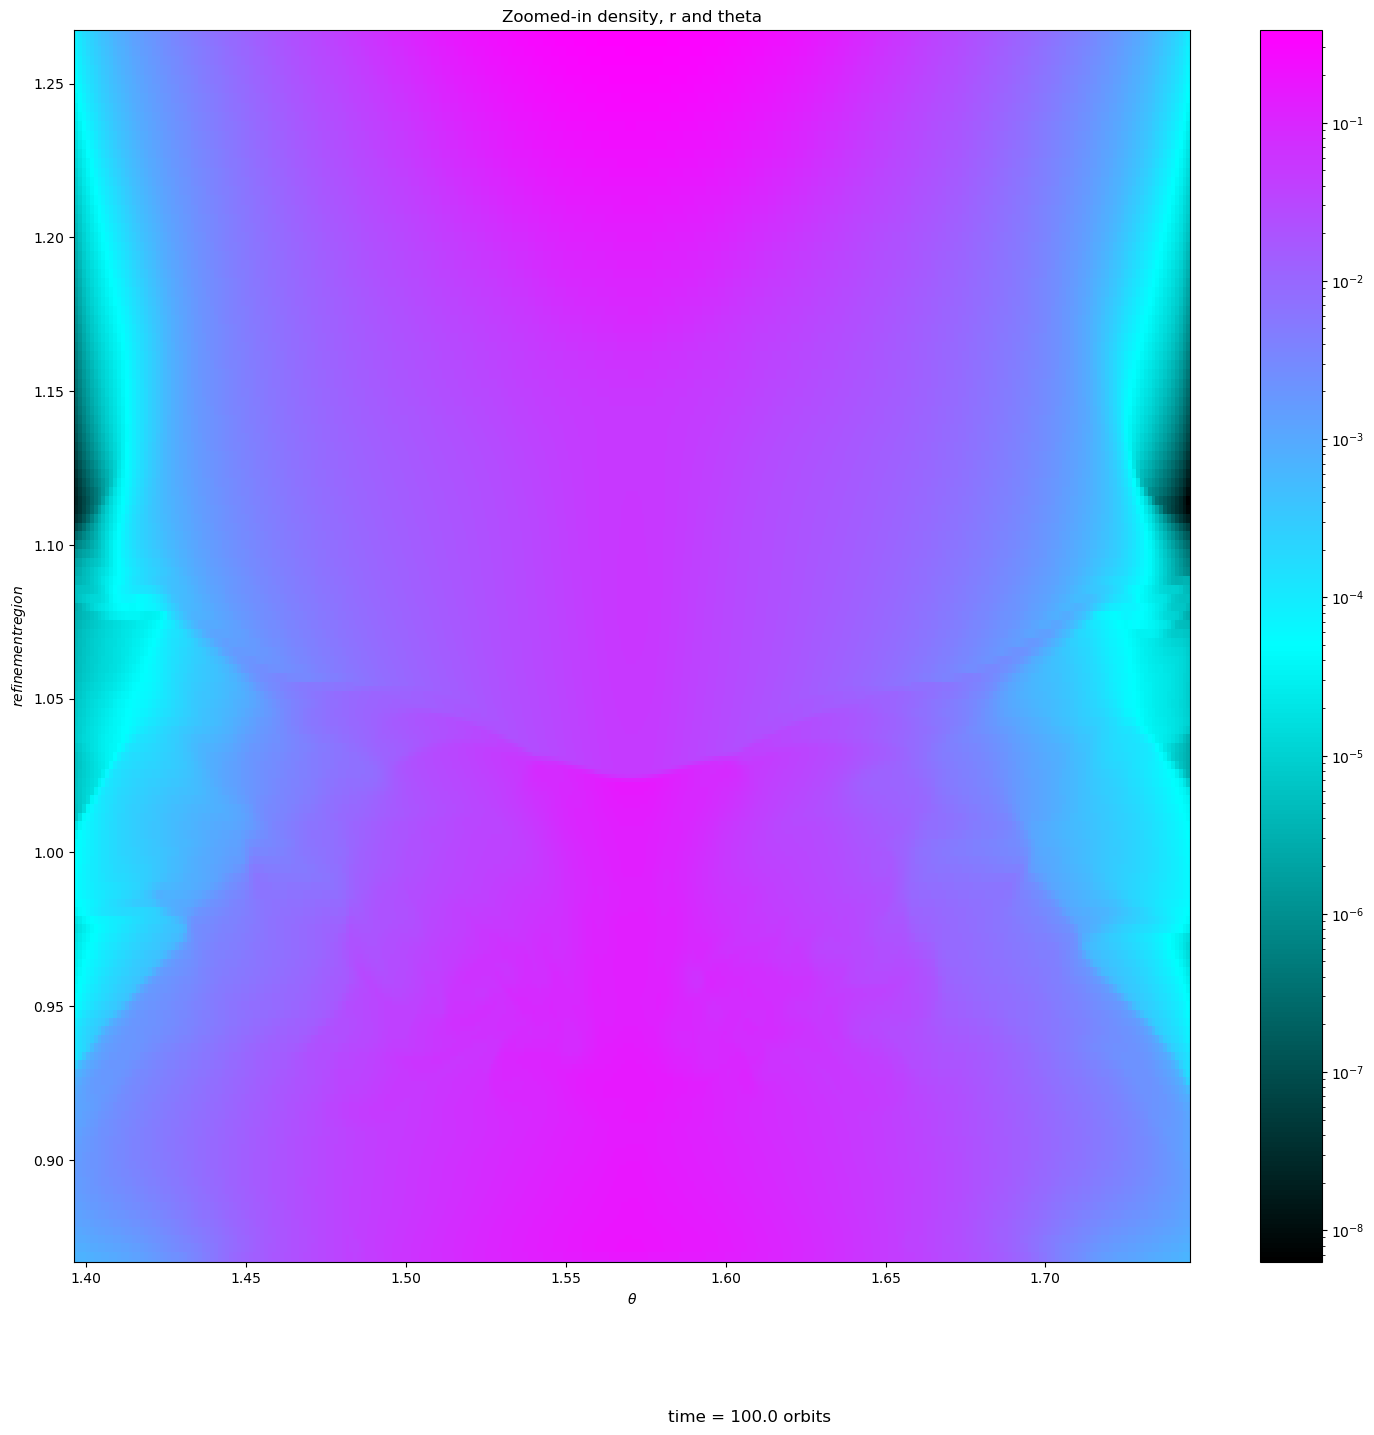

In [16]:
plots, axes = plt.subplots(figsize=(18,16))

plt.xlabel('$\\theta$')
plt.ylabel('$ refinement region$')
minval=min(data['rho'][phipos,:,:][0])
maxval=max(data['rho'][phipos,:,:][0])

norm=matplotlib.colors.LogNorm()
xmesh,zmesh=np.meshgrid(data['x2f'],data['x1f'])
im=axes.pcolormesh(xmesh,zmesh,data['rho'][phipos,:,:].T,cmap=cmap, norm=norm)     

cbar=plots.colorbar(im, ax=axes)

ratex = 40
ratez = 12

U = data['vel1'][phipos,:,:].T[::ratex][:,::ratez]
V = data['vel2'][phipos,:,:].T[::ratex][:,::ratez]

x = np.linspace(data['x1f'][0], data['x1f'][-1], U.shape[0])#[::ratex]
z = np.linspace(data['x2f'][0], data['x2f'][-1], U.shape[1])#[::ratez]

X,Z = np.meshgrid(z,x)

#  Varying density along a streamline
# plt.streamplot(X,Z, U, V, color = 'indigo')


plt.figtext(0.5, 0.01, 'time = '+str(data['Time'] // (2*np.pi)) + ' orbits', ha="center", fontsize=12)
plt.title('Zoomed-in density, r and theta')
axes.set_aspect('auto')
#plt.style.use('dark_background')
plt.show()

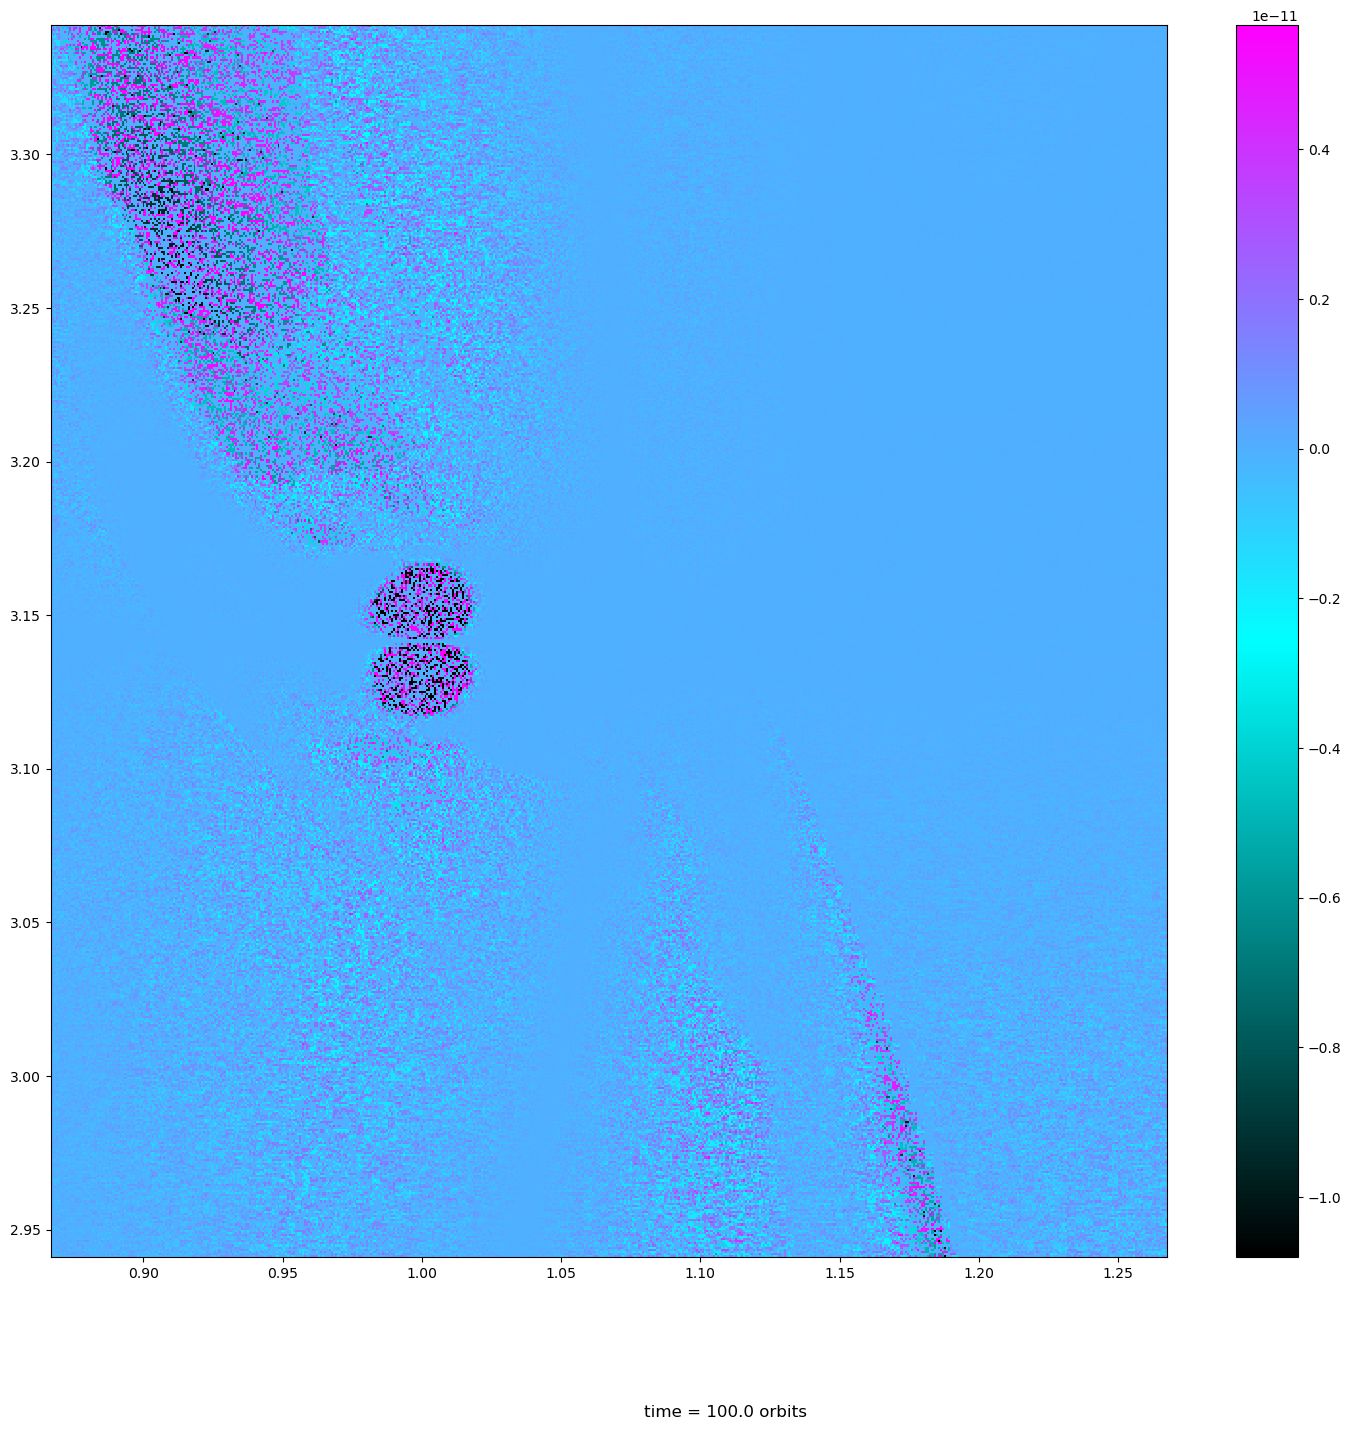

In [108]:
plots, axes = plt.subplots(figsize=(18,16))

# plt.xlabel('$\\theta$')
# plt.ylabel('$ refinement region$')
minval=min(data['rho'][:,thetapos,:][0])
maxval=max(data['rho'][:,thetapos,:][0])
# ridx = np.where(data['x1f'])[0][:-1]
# thetaidx = np.where(data['x2f'])[0][:-1]

norm=matplotlib.colors.Normalize(vmin=min(Flux_L[:,thetapos,:][0]), vmax=max(Flux_L[:,thetapos,:][0]))
xmesh,zmesh=np.meshgrid(data['x1f'],data['x3f'])
im=axes.pcolormesh(xmesh,zmesh,Flux_L[:,thetapos,:],cmap=cmap, norm=norm)     

cbar=plots.colorbar(im, ax=axes)

ratex = 40
ratez = 12

U = data['vel1'][:,thetapos,:].T[::ratex][:,::ratez]
V = data['vel3'][:,thetapos,:].T[::ratex][:,::ratez]

x = np.linspace(data['x1f'][0], data['x1f'][-1], U.shape[0])#[::ratex]
z = np.linspace(data['x3f'][0], data['x3f'][-1], U.shape[1])#[::ratez]

X,Z = np.meshgrid(z,x)

#  Varying density along a streamline
# plt.streamplot(X,Z, U, V, color = 'indigo')


plt.figtext(0.5, 0.01, 'time = '+str(data['Time'] // (2*np.pi)) + ' orbits', ha="center", fontsize=12)
# plt.title('Zoomed-in density, r and theta')
axes.set_aspect('auto')
#plt.style.use('dark_background')
plt.show()

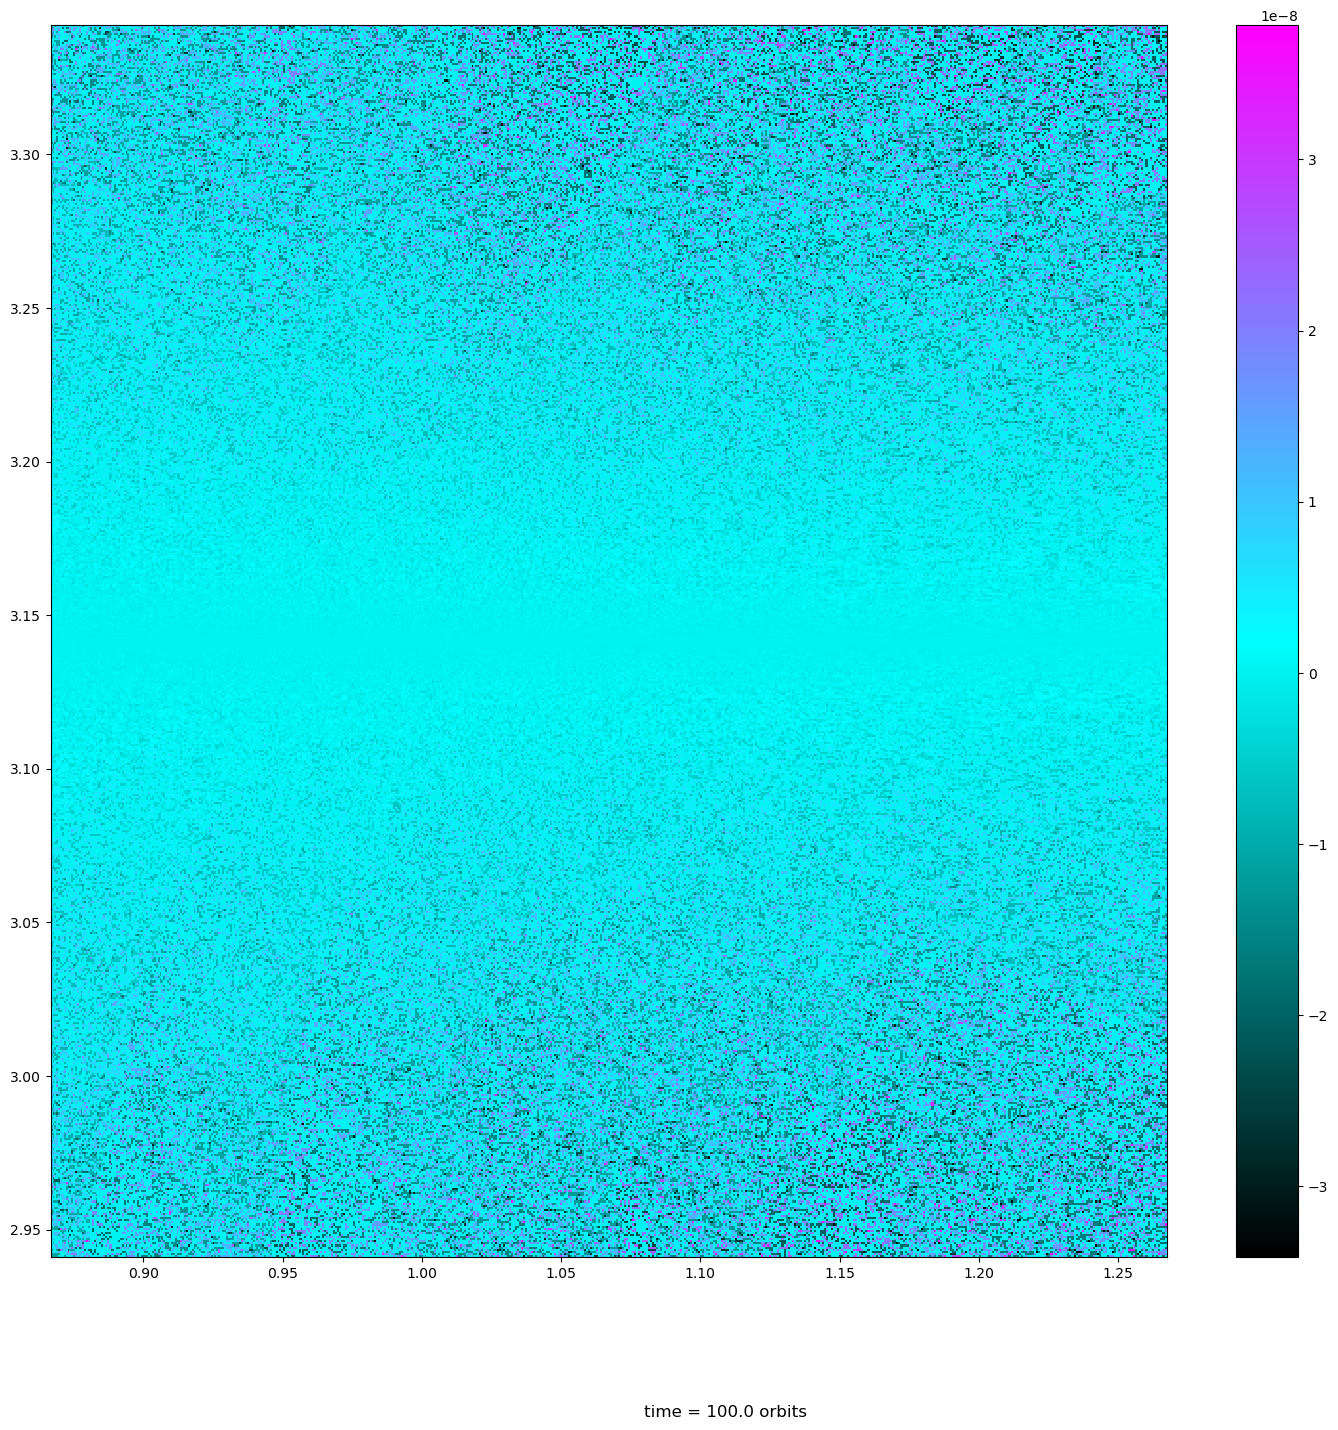

In [109]:
plots, axes = plt.subplots(figsize=(18,16))

# plt.xlabel('$\\theta$')
# plt.ylabel('$ refinement region$')
minval=min(data['rho'][:,thetapos,:][0])
maxval=max(data['rho'][:,thetapos,:][0])
# ridx = np.where(data['x1f'])[0][:-1]
# thetaidx = np.where(data['x2f'])[0][:-1]

norm=matplotlib.colors.Normalize(vmin=min(norm_Flux_l[:,thetapos,:][0]), vmax=max(norm_Flux_l[:,thetapos,:][0]))
xmesh,zmesh=np.meshgrid(data['x1f'],data['x3f'])
im=axes.pcolormesh(xmesh,zmesh,norm_Flux_l[:,thetapos,:],cmap=cmap, norm=norm)     

cbar=plots.colorbar(im, ax=axes)

ratex = 40
ratez = 12

U = data['vel1'][:,thetapos,:].T[::ratex][:,::ratez]
V = data['vel3'][:,thetapos,:].T[::ratex][:,::ratez]

x = np.linspace(data['x1f'][0], data['x1f'][-1], U.shape[0])#[::ratex]
z = np.linspace(data['x3f'][0], data['x3f'][-1], U.shape[1])#[::ratez]

X,Z = np.meshgrid(z,x)

#  Varying density along a streamline
# plt.streamplot(X,Z, U, V, color = 'indigo')


plt.figtext(0.5, 0.01, 'time = '+str(data['Time'] // (2*np.pi)) + ' orbits', ha="center", fontsize=12)
# plt.title('Zoomed-in density, r and theta')
axes.set_aspect('auto')
#plt.style.use('dark_background')
plt.show()

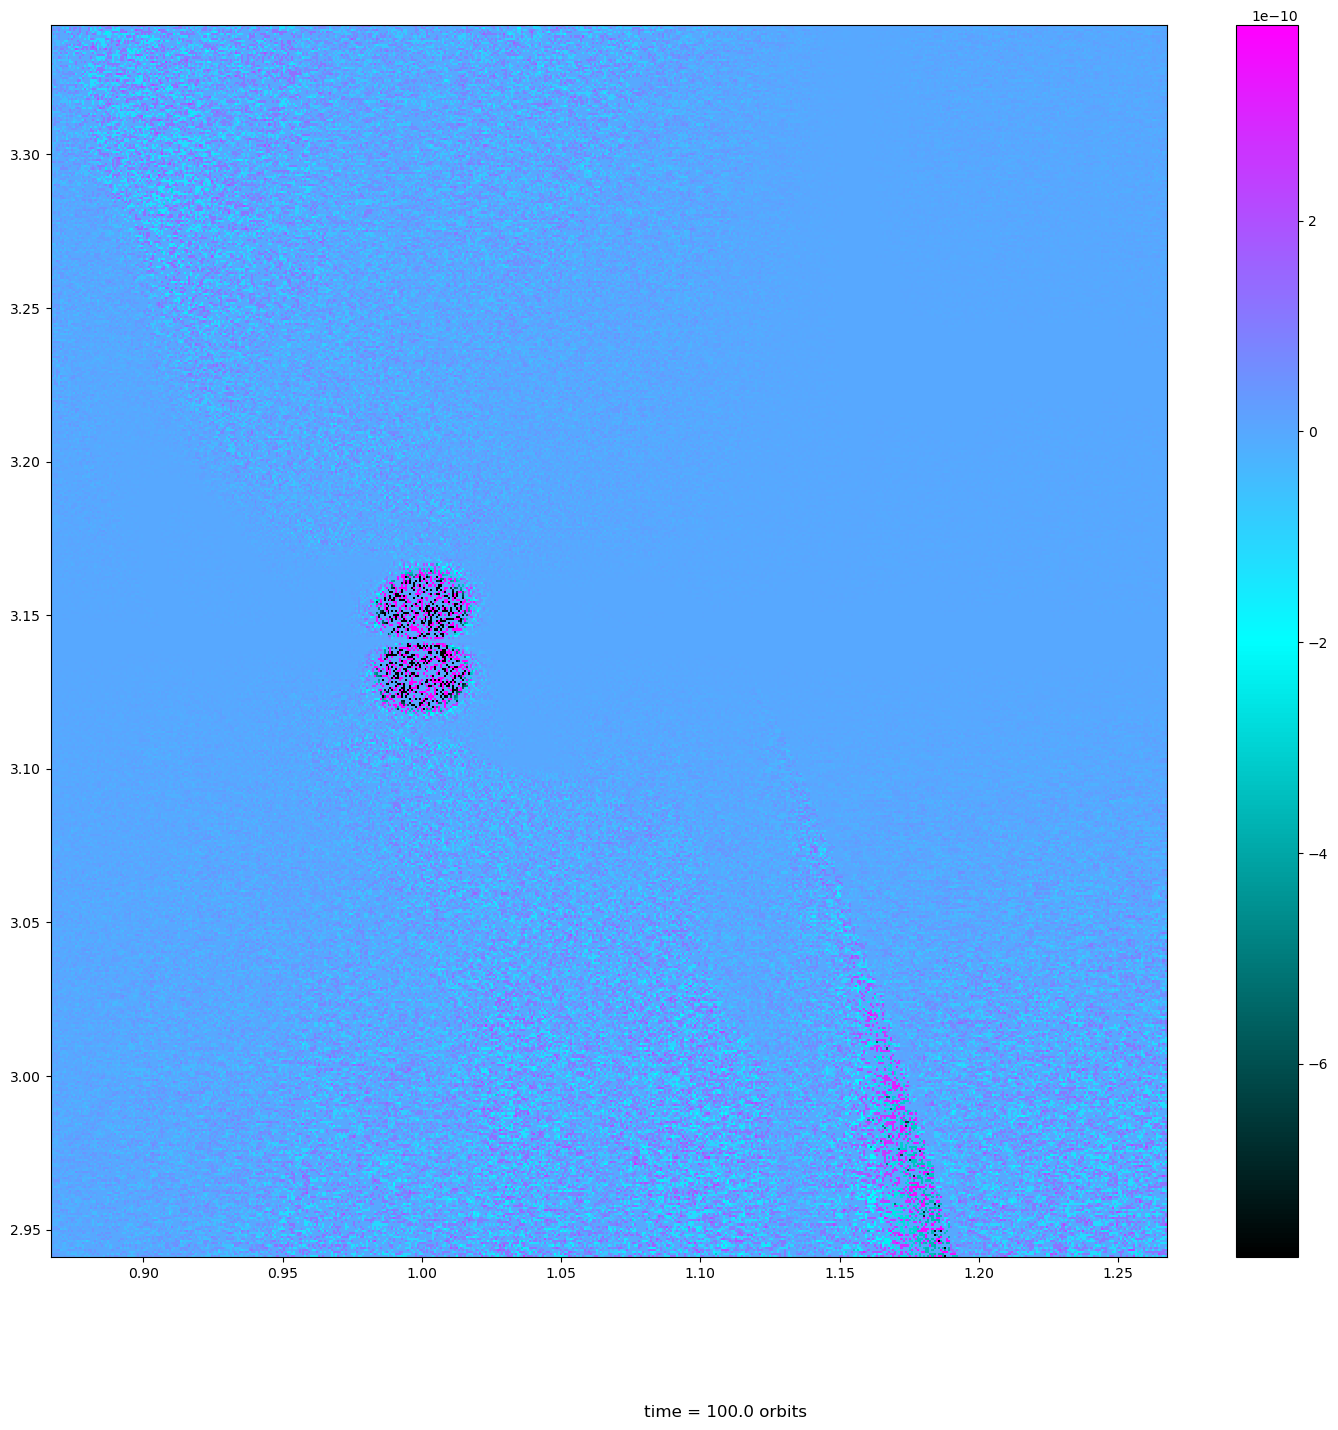

In [144]:
plots, axes = plt.subplots(figsize=(18,16))

# plt.xlabel('$\\theta$')
# plt.ylabel('$ refinement region$')
minval=min(data['rho'][:,thetapos,:][0])
maxval=max(data['rho'][:,thetapos,:][0])
# ridx = np.where(data['x1f'])[0][:-1]
# thetaidx = np.where(data['x2f'])[0][:-1]

norm=matplotlib.colors.Normalize(vmin=min((Lz/1)[:,thetapos,:][0]), vmax=max((Lz/1)[:,thetapos,:][0]))
xmesh,zmesh=np.meshgrid(data['x1f'],data['x3f'])
im=axes.pcolormesh(xmesh,zmesh,(Lz/1)[:,thetapos,:],cmap=cmap, norm=norm)     

cbar=plots.colorbar(im, ax=axes)

ratex = 40
ratez = 12

U = data['vel1'][:,thetapos,:].T[::ratex][:,::ratez]
V = data['vel3'][:,thetapos,:].T[::ratex][:,::ratez]

x = np.linspace(data['x1f'][0], data['x1f'][-1], U.shape[0])#[::ratex]
z = np.linspace(data['x3f'][0], data['x3f'][-1], U.shape[1])#[::ratez]

X,Z = np.meshgrid(z,x)

#  Varying density along a streamline
# plt.streamplot(X,Z, U, V, color = 'indigo')


plt.figtext(0.5, 0.01, 'time = '+str(data['Time'] // (2*np.pi)) + ' orbits', ha="center", fontsize=12)
# plt.title('Zoomed-in density, r and theta')
axes.set_aspect('auto')
#plt.style.use('dark_background')
plt.show()

In [18]:
ridx = np.where(data['x1f']>=0.95)[0][:-1]
thetaidx = np.where(data['x2f']>=1.55)[0][:-1]

In [19]:
data['vel1'].shape

(588, 1152, 560)

In [28]:
np.mean(data['vel1'][:,thetaidx][:,:,ridx], axis=0).shape

(644, 437)

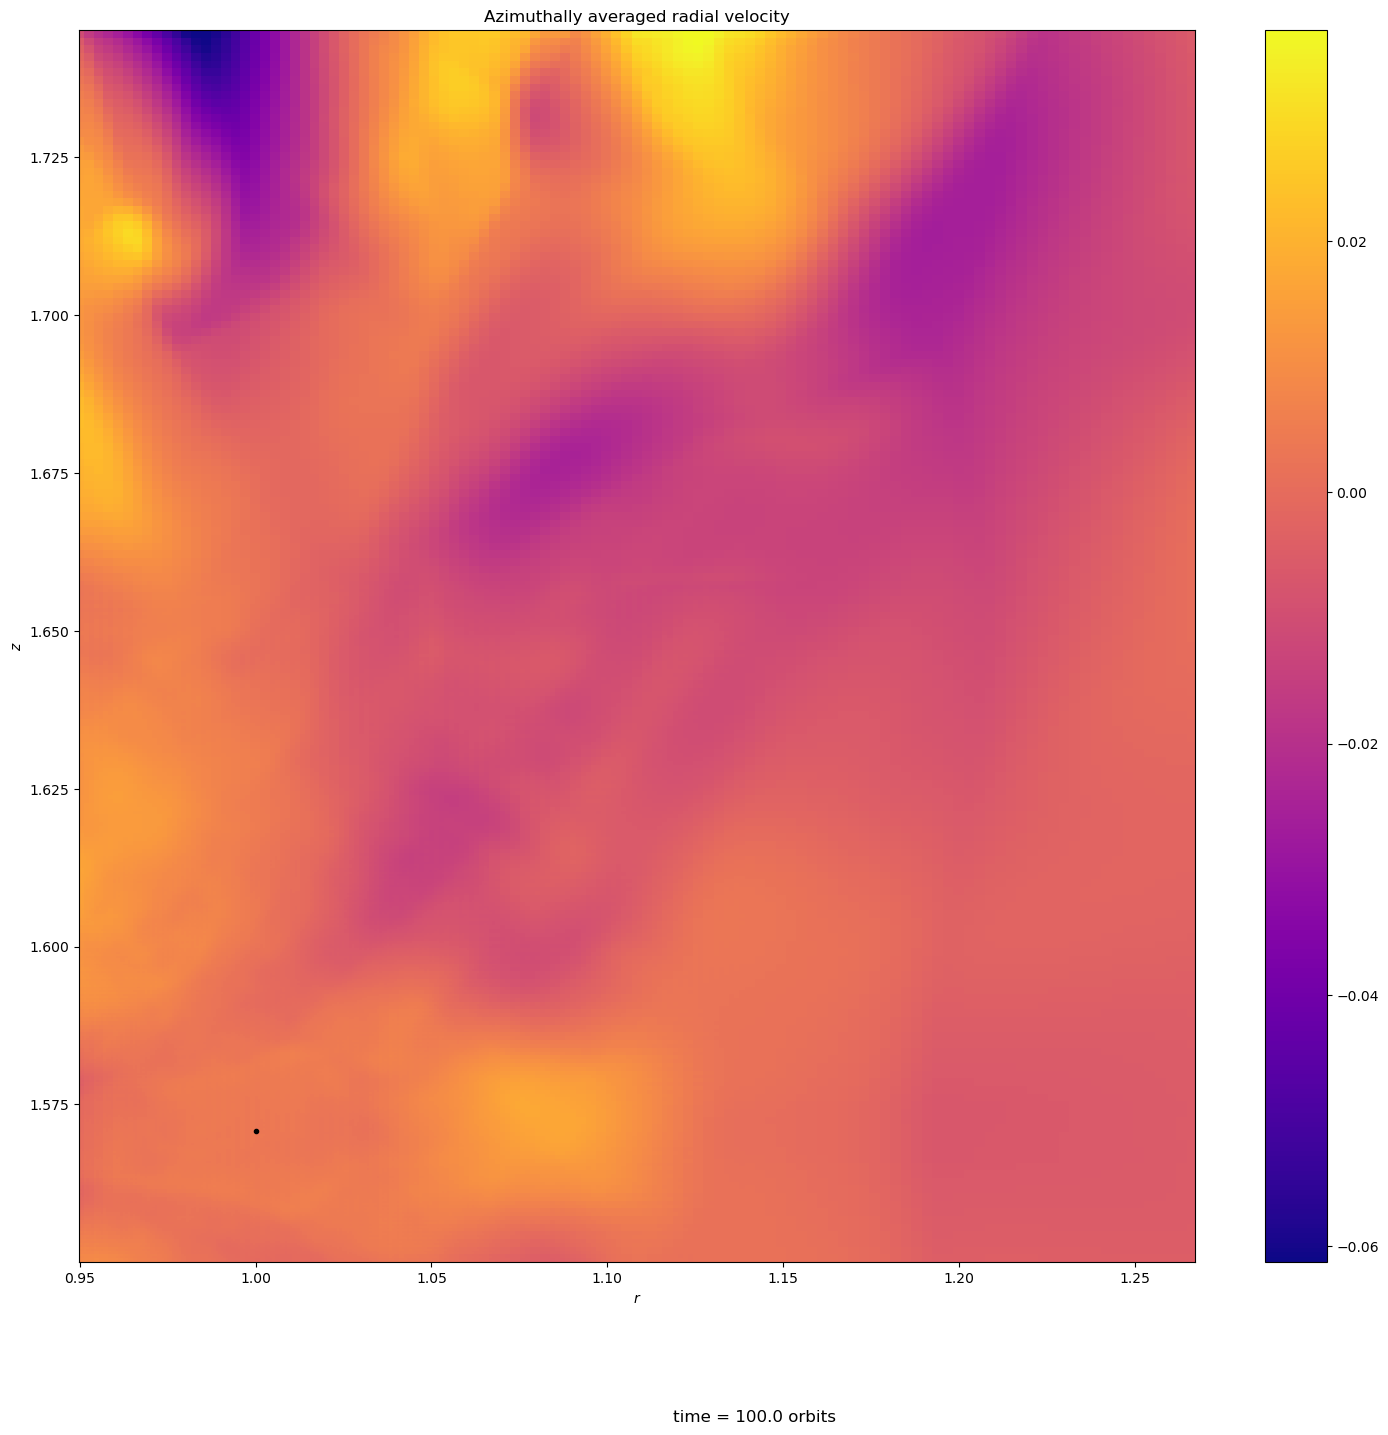

In [30]:
plots, axes = plt.subplots(figsize=(18,16))

plt.xlabel('$r$')
plt.ylabel('$z$')
minval=min(data['rho'][:,thetapos,:][0])
maxval=max(data['rho'][:,thetapos,:][0])
ridx = np.where(data['x1f']>=0.95)[0][:-1]
thetaidx = np.where(data['x2f']>=1.55)[0][:-1]

norm=matplotlib.colors.Normalize(vmin=min(np.mean(data['vel1'], axis=0)[0]), vmax=max(np.mean(data['vel1'], axis=0)[0]))
xmesh,zmesh=np.meshgrid(data['x1f'][ridx],data['x2f'][thetaidx])
im=axes.pcolormesh(xmesh,zmesh,np.mean(data['vel1'][:,thetaidx][:,:,ridx], axis=0),cmap='plasma', norm=norm)     

cbar=plots.colorbar(im, ax=axes)

ratex = 40
ratez = 12

U = data['vel1'][:,thetapos,:].T[::ratex][:,::ratez]
V = data['vel3'][:,thetapos,:].T[::ratex][:,::ratez]

x = np.linspace(data['x1f'][0], data['x1f'][-1], U.shape[0])#[::ratex]
z = np.linspace(data['x3f'][0], data['x3f'][-1], U.shape[1])#[::ratez]

X,Z = np.meshgrid(z,x)

pos_vel = np.where(np.mean(data['vel1'], axis=0)[thetaidx][:,ridx]>0)

# plt.plot(xmesh,np.mean(data['vel1'], axis=0)[np.mean(data['vel1'], axis=0)[:,1]>0])

#  Varying density along a streamline
# plt.streamplot(X,Z, U, V, color = 'indigo')
plt.plot(1, np.pi/2, 'k.')

plt.figtext(0.5, 0.01, 'time = '+str(data['Time'] // (2*np.pi)) + ' orbits', ha="center", fontsize=12)
plt.title('Azimuthally averaged radial velocity')
axes.set_aspect('auto')
#plt.style.use('dark_background')
plt.show()

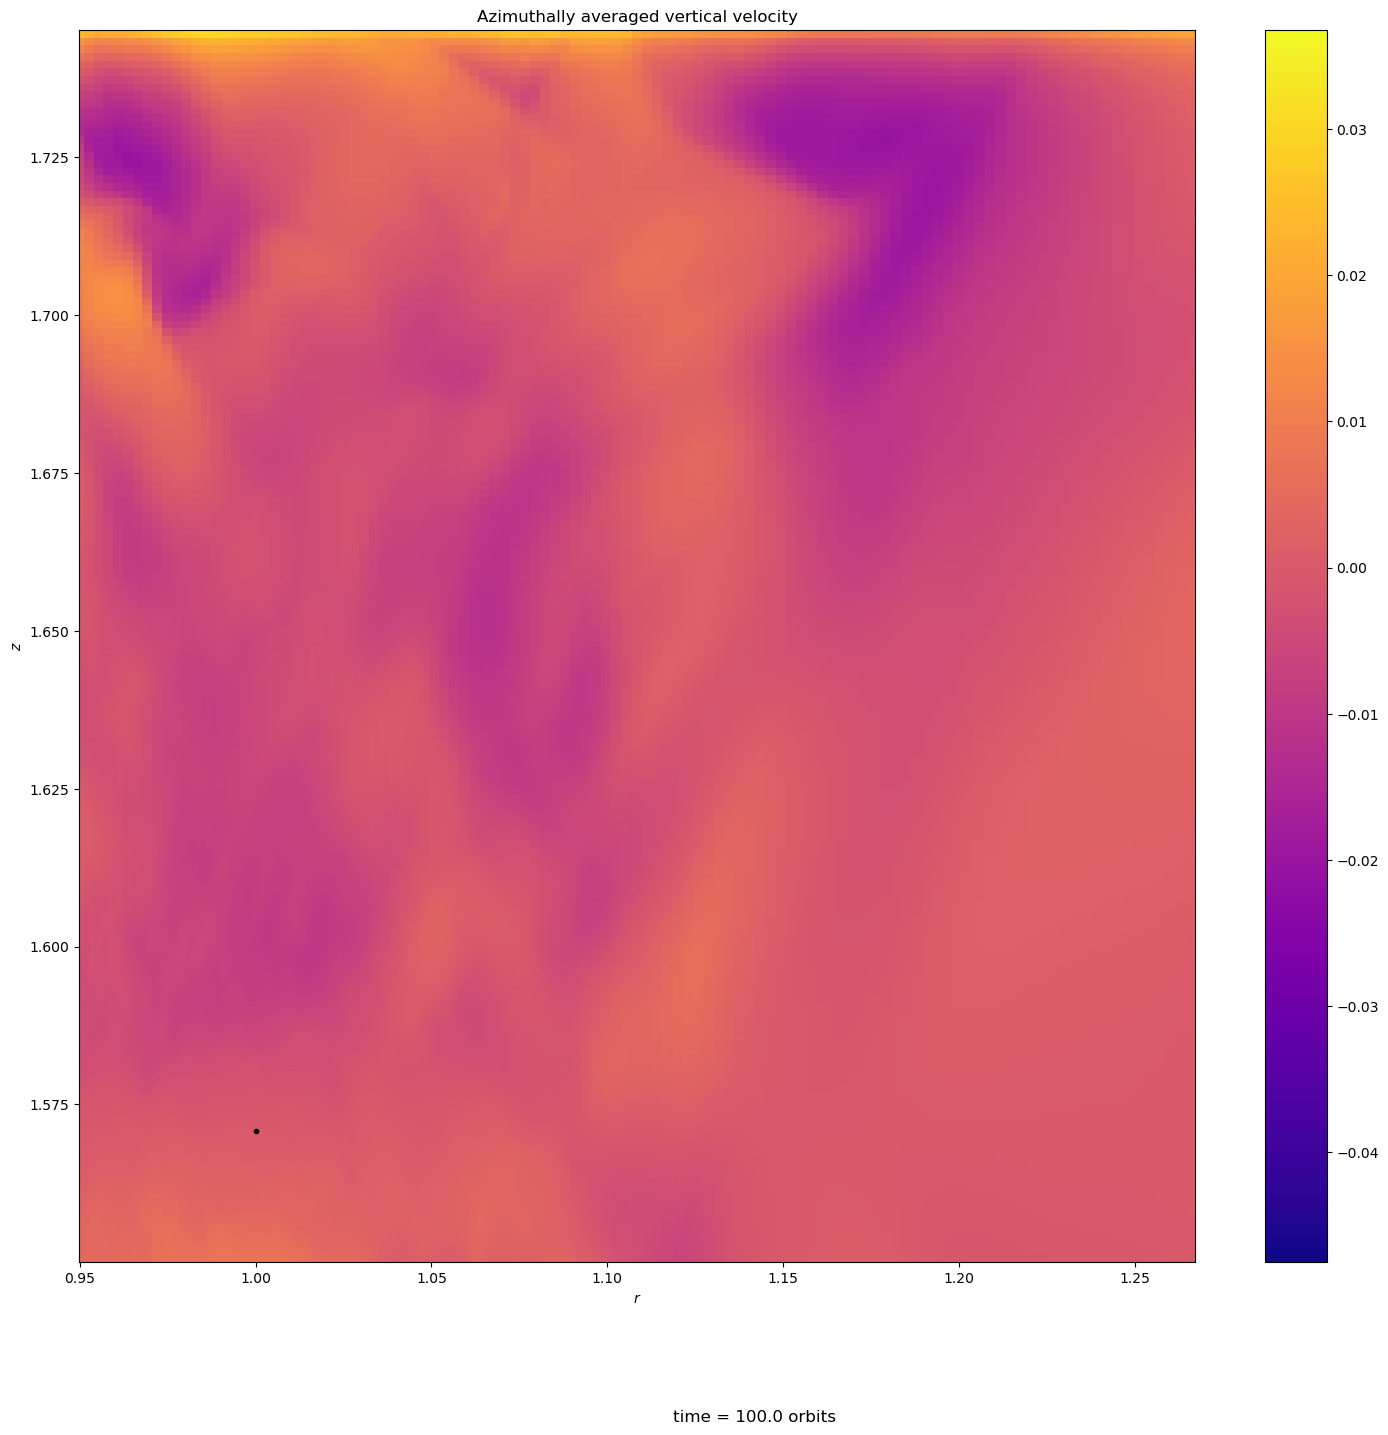

In [118]:
plots, axes = plt.subplots(figsize=(18,16))

plt.xlabel('$r$')
plt.ylabel('$z$')
minval=min(data['rho'][:,thetapos,:][0])
maxval=max(data['rho'][:,thetapos,:][0])
ridx = np.where(data['x1f']>=0.95)[0][:-1]
thetaidx = np.where(data['x2f']>=1.55)[0][:-1]

norm=matplotlib.colors.Normalize(vmin=min(np.mean(data['vel2'], axis=0)[0]), vmax=max(np.mean(data['vel1'], axis=0)[0]))
xmesh,zmesh=np.meshgrid(data['x1f'][ridx],data['x2f'][thetaidx])
im=axes.pcolormesh(xmesh,zmesh,np.mean(data['vel2'], axis=0)[thetaidx][:,ridx],cmap='plasma', norm=norm)     

cbar=plots.colorbar(im, ax=axes)

ratex = 40
ratez = 12

U = data['vel1'][:,thetapos,:].T[::ratex][:,::ratez]
V = data['vel3'][:,thetapos,:].T[::ratex][:,::ratez]

x = np.linspace(data['x1f'][0], data['x1f'][-1], U.shape[0])#[::ratex]
z = np.linspace(data['x3f'][0], data['x3f'][-1], U.shape[1])#[::ratez]

X,Z = np.meshgrid(z,x)

#  Varying density along a streamline
# plt.streamplot(X,Z, U, V, color = 'indigo')
plt.plot(1, np.pi/2, 'k.')

plt.figtext(0.5, 0.01, 'time = '+str(data['Time'] // (2*np.pi)) + ' orbits', ha="center", fontsize=12)
plt.title('Azimuthally averaged vertical velocity')
axes.set_aspect('auto')
#plt.style.use('dark_background')
plt.show()

In [19]:
dist.shape

(588, 1152, 560)

In [23]:
indices_polar

array([[[   0],
        [   1],
        [   2],
        ...,
        [1149],
        [1150],
        [1151]]])

In [35]:
np.arctan2(y,x).shape

(588, 1152, 560)

In [20]:
# Define the location around which to azimuthally average
center = (1, np.pi/2, np.pi)

# Define the dimensions of the velocity data
n_azimuthal, n_polar, n_radial = data['vel1'].shape

# Create grids of indices for each direction
indices_azimuthal, indices_polar, indices_radial = np.ogrid[:n_azimuthal, :n_polar, :n_radial]

# Calculate the distances from the center in each direction
# d_azimuthal = np.mod(np.abs(indices_azimuthal - center[0]), n_azimuthal)
# d_polar = np.abs(indices_polar - center[1])
# d_radial = np.abs(indices_radial - center[2])

# # Calculate the radial distances from the center
# radius = np.sqrt(d_azimuthal**2 + d_polar**2 + d_radial**2)

# # Calculate the azimuthal angles from the new center
# theta = np.arccos(d_polar/radius)
# phi = np.arctan2(d_azimuthal, d_radial)

new_theta = np.arccos(z/dist)
new_phi = np.arctan2(y/x)

# Create a mask to select the data within a certain radius around the new center
# mask = np.logical_and.reduce((radius >= 0.9, radius <= 1.1, theta >= np.pi/2 - 0.1, theta <= np.pi/2 + 0.1, phi >= np.pi - 0.1, phi <= np.pi + 0.1))

# # Apply the mask to select the data within a certain radius around the new center
# data = vr[mask]

# Calculate the new azimuthal angles around the new center
azimuthal_new = np.mod(np.arange(n_azimuthal) - center[2] + n_azimuthal//2, n_azimuthal) - n_azimuthal//2
azimuthal_int = np.floor(center[2] + azimuthal_new).astype(int)

# Azimuthally average the data around the new center
az_avg = np.zeros((n_polar, n_radial))
for i in range(n_azimuthal-1):
    az_avg += data['vel1'][azimuthal_int[i],:,:] * (azimuthal_new[i+1] - azimuthal_new[i])

az_avg /= (azimuthal_new[-1] - azimuthal_new[0])


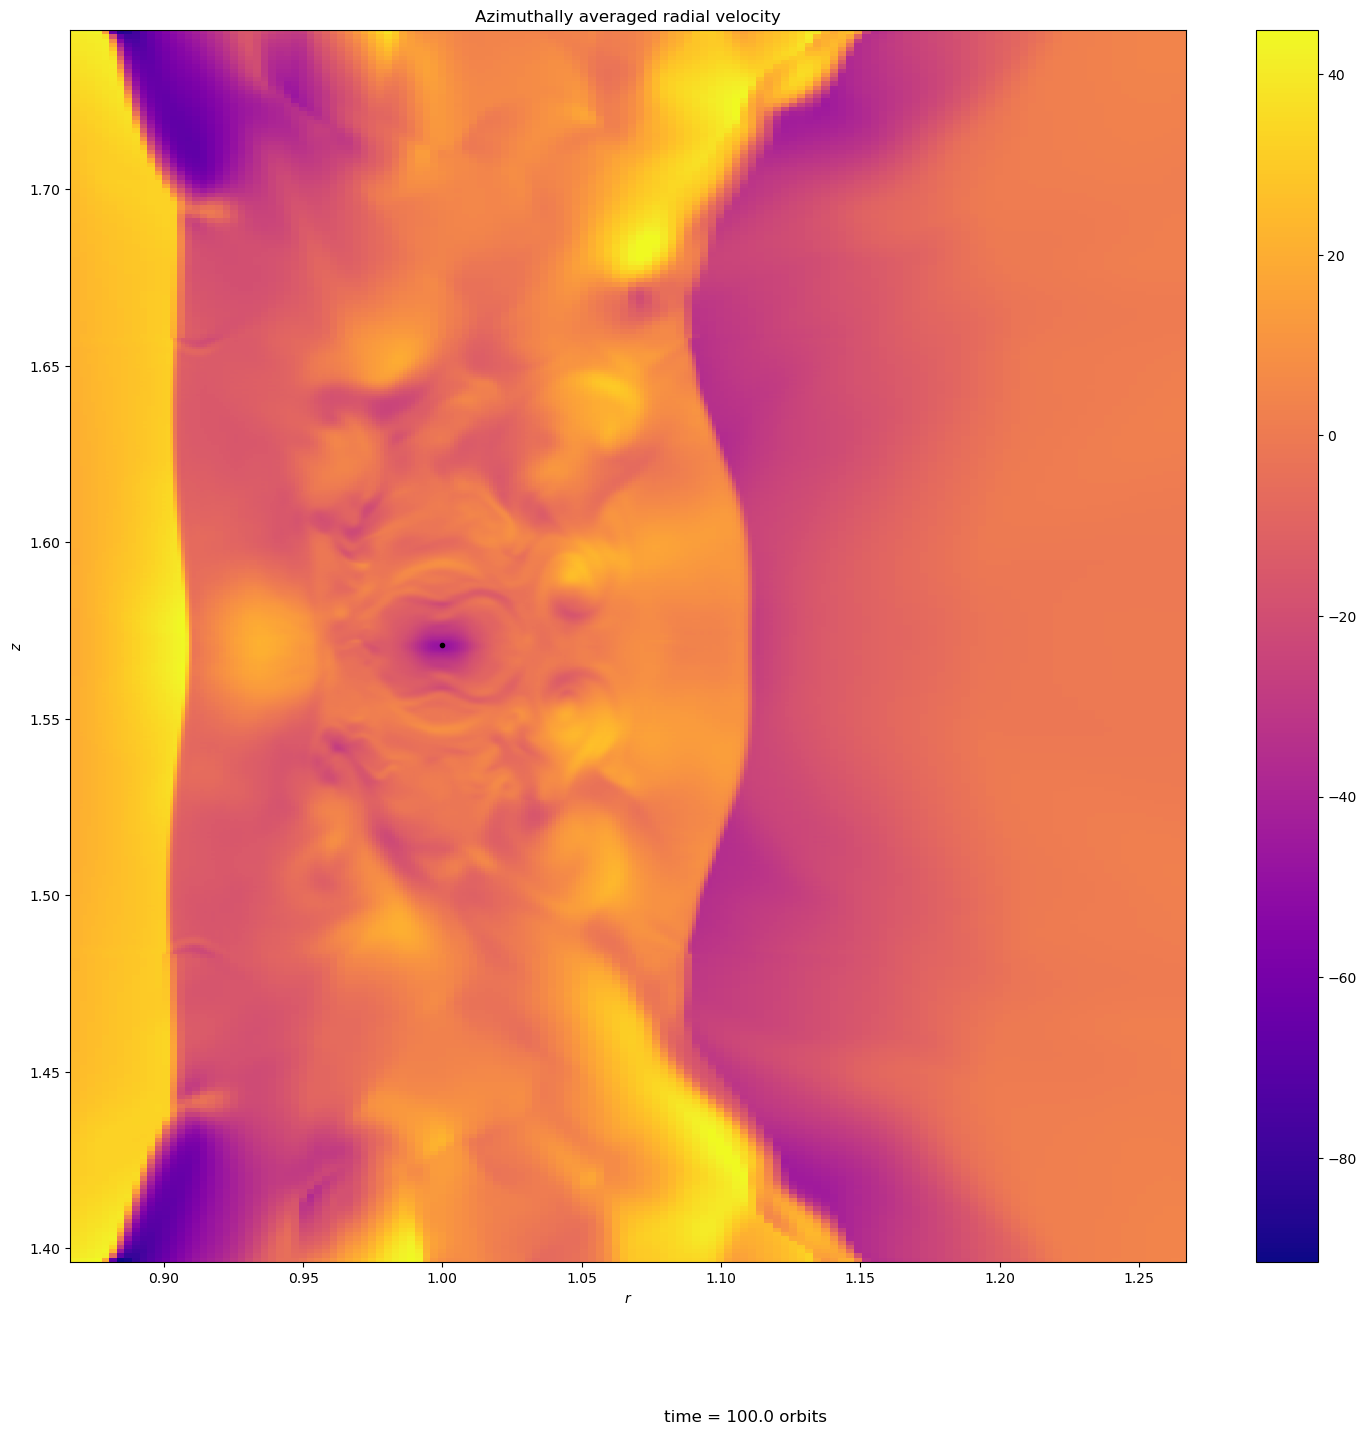

In [21]:
plots, axes = plt.subplots(figsize=(18,16))

plt.xlabel('$r$')
plt.ylabel('$z$')
minval=min(data['rho'][:,thetapos,:][0])
maxval=max(data['rho'][:,thetapos,:][0])
ridx = np.where(data['x1f']>=0.75)[0][:-1]
thetaidx = np.where(data['x2f']>=1.25)[0][:-1]

norm=matplotlib.colors.Normalize(vmin=min(az_avg[0]), vmax=max(az_avg[0]))
xmesh,zmesh=np.meshgrid(data['x1f'][ridx],data['x2f'][thetaidx])
im=axes.pcolormesh(xmesh,zmesh,az_avg[thetaidx][:,ridx],cmap='plasma', norm=norm)     

cbar=plots.colorbar(im, ax=axes)

ratex = 40
ratez = 12

U = data['vel1'][:,thetapos,:].T[::ratex][:,::ratez]
V = data['vel3'][:,thetapos,:].T[::ratex][:,::ratez]

x = np.linspace(data['x1f'][0], data['x1f'][-1], U.shape[0])#[::ratex]
z = np.linspace(data['x3f'][0], data['x3f'][-1], U.shape[1])#[::ratez]

X,Z = np.meshgrid(z,x)

#  Varying density along a streamline
# plt.streamplot(X,Z, U, V, color = 'indigo')
plt.plot(1, np.pi/2, 'k.')

plt.figtext(0.5, 0.01, 'time = '+str(data['Time'] // (2*np.pi)) + ' orbits', ha="center", fontsize=12)
plt.title('Azimuthally averaged radial velocity')
axes.set_aspect('auto')
#plt.style.use('dark_background')
plt.show()

In [22]:
# Define the location around which to azimuthally average
center = (1, np.pi/2, np.pi)

# Define the dimensions of the velocity data
n_azimuthal, n_polar, n_radial = data['vel2'].shape

# Create grids of indices for each direction
indices_azimuthal, indices_polar, indices_radial = np.ogrid[:n_azimuthal, :n_polar, :n_radial]

# Calculate the distances from the center in each direction
d_azimuthal = np.mod(np.abs(indices_azimuthal - center[0]), n_azimuthal)
d_polar = np.abs(indices_polar - center[1])
d_radial = np.abs(indices_radial - center[2])

# Calculate the radial distances from the center
radius = np.sqrt(d_azimuthal**2 + d_polar**2 + d_radial**2)

# Calculate the azimuthal angles from the new center
theta = np.arccos(d_polar/radius)
phi = np.arctan2(d_azimuthal, d_radial)

# Create a mask to select the data within a certain radius around the new center
# mask = np.logical_and.reduce((radius >= 0.9, radius <= 1.1, theta >= np.pi/2 - 0.1, theta <= np.pi/2 + 0.1, phi >= np.pi - 0.1, phi <= np.pi + 0.1))

# # Apply the mask to select the data within a certain radius around the new center
# data = vr[mask]

# Calculate the new azimuthal angles around the new center
azimuthal_new = np.mod(np.arange(n_azimuthal) - center[2] + n_azimuthal//2, n_azimuthal) - n_azimuthal//2
azimuthal_int = np.floor(center[2] + azimuthal_new).astype(int)

# Azimuthally average the data around the new center
az_avg = np.zeros((n_polar, n_radial))
for i in range(n_azimuthal-1):
    az_avg += data['vel2'][azimuthal_int[i],:,:] * (azimuthal_new[i+1] - azimuthal_new[i])

az_avg /= (azimuthal_new[-1] - azimuthal_new[0])


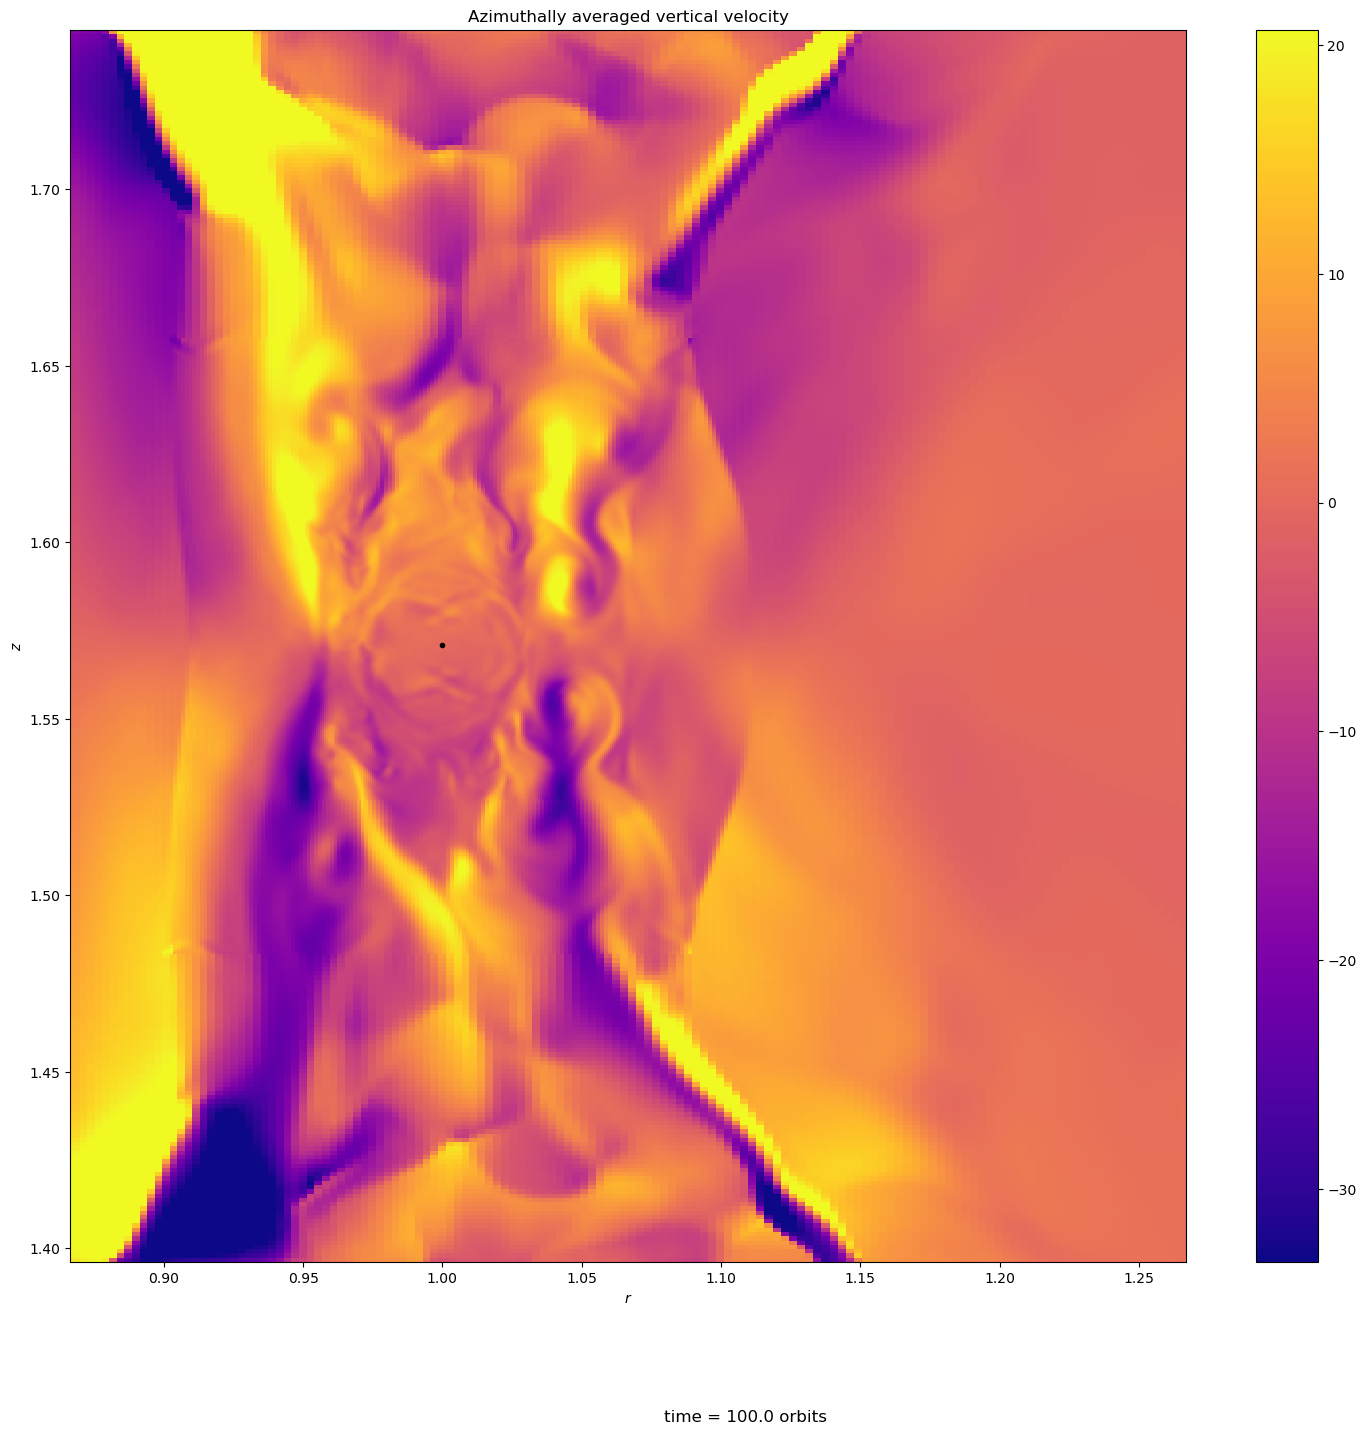

In [23]:
plots, axes = plt.subplots(figsize=(18,16))

plt.xlabel('$r$')
plt.ylabel('$z$')
minval=min(data['rho'][:,thetapos,:][0])
maxval=max(data['rho'][:,thetapos,:][0])
ridx = np.where(data['x1f']>=0.75)[0][:-1]
thetaidx = np.where(data['x2f']>=1.25)[0][:-1]

norm=matplotlib.colors.Normalize(vmin=min(az_avg[0]), vmax=max(az_avg[0]))
xmesh,zmesh=np.meshgrid(data['x1f'][ridx],data['x2f'][thetaidx])
im=axes.pcolormesh(xmesh,zmesh,az_avg[thetaidx][:,ridx],cmap='plasma', norm=norm)     

cbar=plots.colorbar(im, ax=axes)

ratex = 40
ratez = 12

U = data['vel1'][:,thetapos,:].T[::ratex][:,::ratez]
V = data['vel3'][:,thetapos,:].T[::ratex][:,::ratez]

x = np.linspace(data['x1f'][0], data['x1f'][-1], U.shape[0])#[::ratex]
z = np.linspace(data['x3f'][0], data['x3f'][-1], U.shape[1])#[::ratez]

X,Z = np.meshgrid(z,x)

#  Varying density along a streamline
# plt.streamplot(X,Z, U, V, color = 'indigo')
plt.plot(1, np.pi/2, 'k.')

plt.figtext(0.5, 0.01, 'time = '+str(data['Time'] // (2*np.pi)) + ' orbits', ha="center", fontsize=12)
plt.title('Azimuthally averaged vertical velocity')
axes.set_aspect('auto')
#plt.style.use('dark_background')
plt.show()

In [24]:
# Define the location around which to azimuthally average
center = (1, np.pi/2, np.pi)

# Define the dimensions of the velocity data
n_azimuthal, n_polar, n_radial = data['rho'].shape

# Create grids of indices for each direction
indices_azimuthal, indices_polar, indices_radial = np.ogrid[:n_azimuthal, :n_polar, :n_radial]

# Calculate the distances from the center in each direction
d_azimuthal = np.mod(np.abs(indices_azimuthal - center[0]), n_azimuthal)
d_polar = np.abs(indices_polar - center[1])
d_radial = np.abs(indices_radial - center[2])

# Calculate the radial distances from the center
radius = np.sqrt(d_azimuthal**2 + d_polar**2 + d_radial**2)

# Calculate the azimuthal angles from the new center
theta = np.arccos(d_polar/radius)
phi = np.arctan2(d_azimuthal, d_radial)

# Create a mask to select the data within a certain radius around the new center
# mask = np.logical_and.reduce((radius >= 0.9, radius <= 1.1, theta >= np.pi/2 - 0.1, theta <= np.pi/2 + 0.1, phi >= np.pi - 0.1, phi <= np.pi + 0.1))

# # Apply the mask to select the data within a certain radius around the new center
# data = vr[mask]

# Calculate the new azimuthal angles around the new center
azimuthal_new = np.mod(np.arange(n_azimuthal) - center[2] + n_azimuthal//2, n_azimuthal) - n_azimuthal//2
azimuthal_int = np.floor(center[2] + azimuthal_new).astype(int)

# Azimuthally average the data around the new center
az_avg = np.zeros((n_polar, n_radial))
for i in range(n_azimuthal-1):
    az_avg += data['rho'][azimuthal_int[i],:,:] * (azimuthal_new[i+1] - azimuthal_new[i])

az_avg /= (azimuthal_new[-1] - azimuthal_new[0])


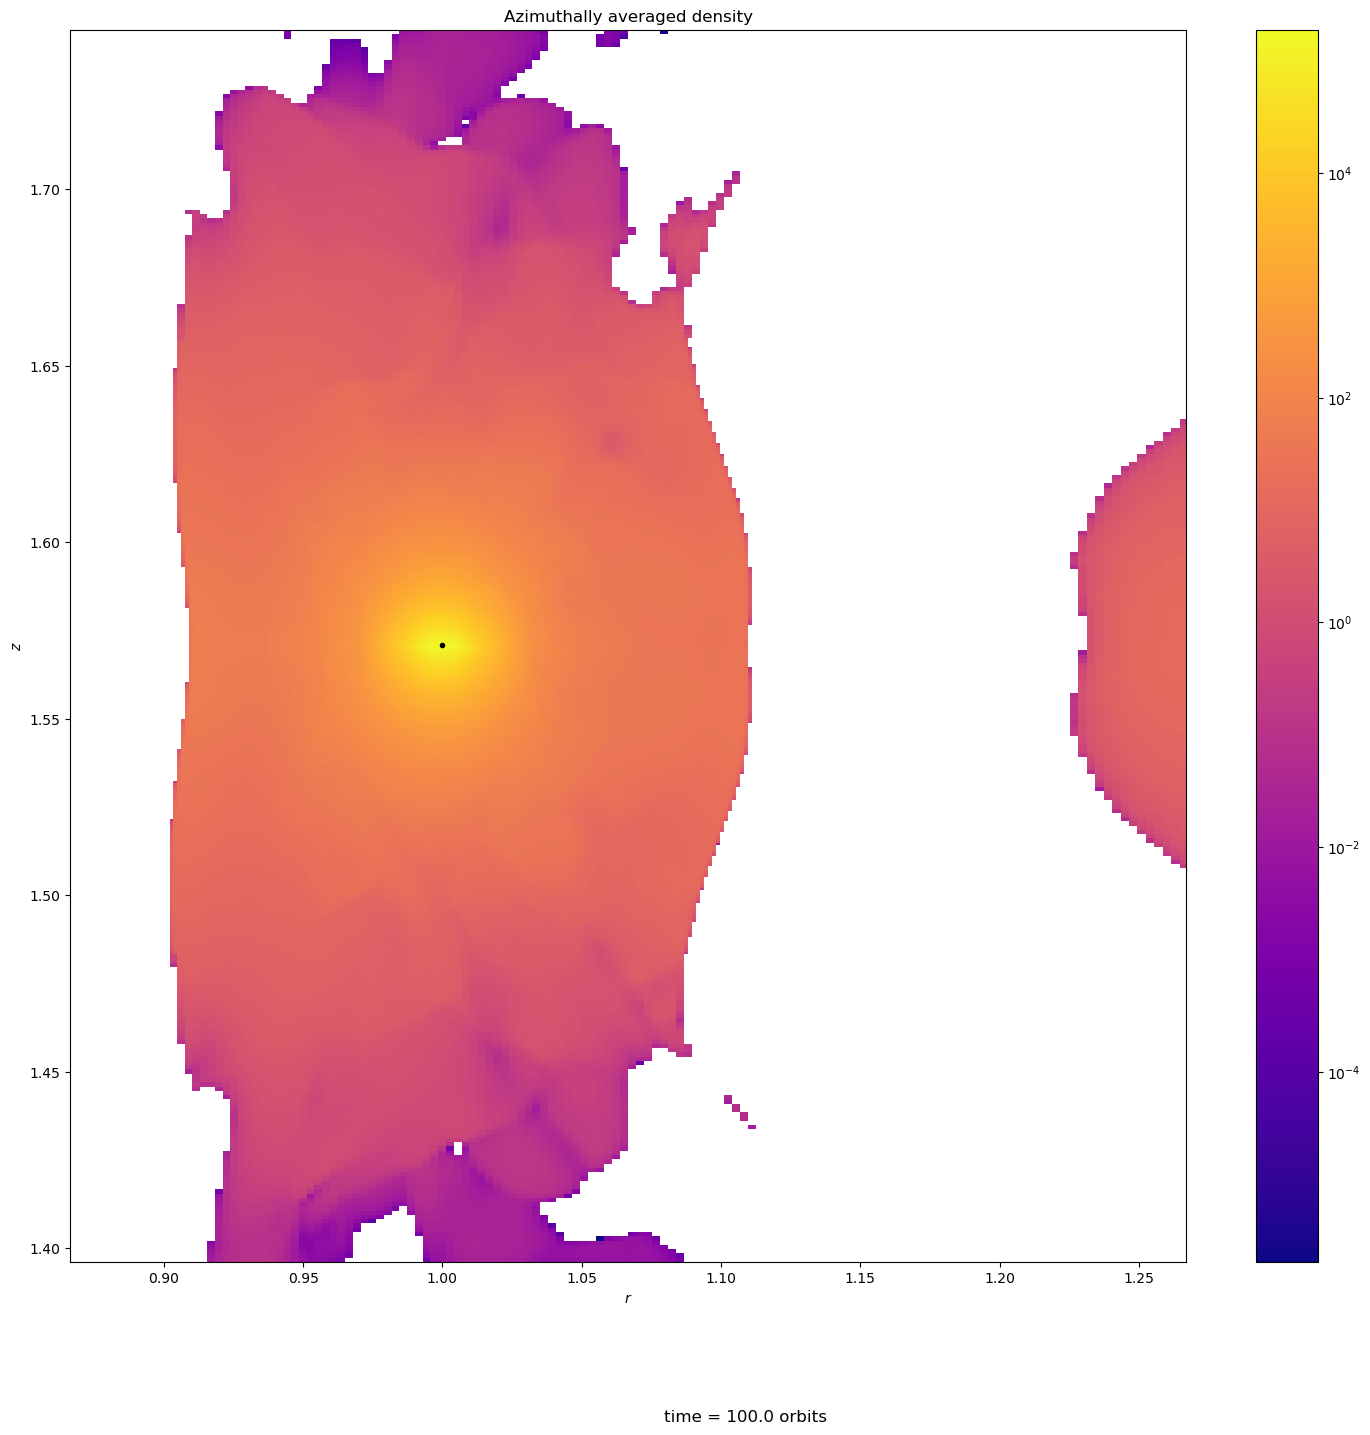

In [27]:
plots, axes = plt.subplots(figsize=(18,16))

plt.xlabel('$r$')
plt.ylabel('$z$')
minval=min(data['rho'][:,thetapos,:][0])
maxval=max(data['rho'][:,thetapos,:][0])
ridx = np.where(data['x1f']>=0.75)[0][:-1]
thetaidx = np.where(data['x2f']>=1.25)[0][:-1]

norm=matplotlib.colors.LogNorm()
xmesh,zmesh=np.meshgrid(data['x1f'][ridx],data['x2f'][thetaidx])
im=axes.pcolormesh(xmesh,zmesh,az_avg[thetaidx][:,ridx],cmap='plasma', norm=norm)     

cbar=plots.colorbar(im, ax=axes)

ratex = 40
ratez = 12

U = data['vel1'][:,thetapos,:].T[::ratex][:,::ratez]
V = data['vel3'][:,thetapos,:].T[::ratex][:,::ratez]

x = np.linspace(data['x1f'][0], data['x1f'][-1], U.shape[0])#[::ratex]
z = np.linspace(data['x3f'][0], data['x3f'][-1], U.shape[1])#[::ratez]

X,Z = np.meshgrid(z,x)

#  Varying density along a streamline
# plt.streamplot(X,Z, U, V, color = 'indigo')
plt.plot(1, np.pi/2, 'k.')

plt.figtext(0.5, 0.01, 'time = '+str(data['Time'] // (2*np.pi)) + ' orbits', ha="center", fontsize=12)
plt.title('Azimuthally averaged density')
axes.set_aspect('auto')
#plt.style.use('dark_background')
plt.show()

In [24]:
# Define the mass of each gas particle (assuming constant density)
dV = 1.  # Replace with the volume element for each particle
m = data['rho'] * dV

# Calculate the angular momentum vector of each gas particle relative to the sphere
Lz = m * (vy * x - vx * y)
Ly = m * (vz * x - vx * z)
Lx = m * (vz * y - vy * z)

# Sum up the angular momentum vectors of all gas particles
L_tot_vec = np.sum([Lx,Ly,Lz], axis=0)

# Calculate the magnitude of the angular momentum vector
L_mag = np.linalg.norm(L_tot_vec)

# Plot the angular momentum vector
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(xp, yp, zp, Lx, Ly, Lz, length=L_mag)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()


: 

: 

In [64]:
# Convert cartesian coordinates of planet to spherical-polar coordinates
theta_p = np.arctan2(0, -1)  # polar angle
phi_p = np.arccos(0)  # azimuthal angle

# Define range of radii to calculate the azimuthal average over
r_max = np.max(dist)
r_min = 0
n_r = 50  # number of radii
r_arr = np.linspace(r_min, r_max, n_r)

# Initialize array to store azimuthally averaged velocities
v_az_avg_arr = np.zeros(n_r)

# Loop over radii
for i in range(n_r):
    # Find indices of cells within radius
    r = r_arr[i]
    indices = np.where(dist <= r)[0]
    
    # Loop over azimuthal angles
    v_phi_avg_arr = np.zeros(len(indices))
    for j in range(len(indices)):
        # Get indices of cell
        ind = indices[j]
        r_ind = np.argmin(np.abs(data['x1v'] - dist[ind]))
        theta_ind = np.argmin(np.abs(data['x2v'] - theta_p))
        phi_ind = np.argmin(np.abs(data['x3v'] - phi_p))
        
        # Get velocities of cell
        vx_cell = vx[phi_ind, theta_ind, r_ind]
        vy_cell = vy[phi_ind, theta_ind, r_ind]
        vz_cell = vz[phi_ind, theta_ind, r_ind]
        
        # Calculate azimuthal velocity and add to array
        v_phi_cell = vy_cell*np.sin(phi_p) - vz_cell*np.cos(phi_p)
        v_phi_avg_arr[j] = v_phi_cell
    
    # Calculate mean azimuthal velocity for radius and add to array
    v_az_avg_arr[i] = np.mean(v_phi_avg_arr)
    
# Plot azimuthally averaged velocity as a function of radius
plt.plot(r_arr, v_az_avg_arr)
plt.xlabel('Radius')
plt.ylabel('Azimuthally averaged velocity')
plt.show()


/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


KeyboardInterrupt: 

In [17]:
rp, thetap, phip = 1, np.pi / 2, np.pi

In [23]:
r_new = np.sqrt(data['x1v'][np.newaxis, np.newaxis,:] ** 2 + rp ** 2 - 2 * data['x1v'][np.newaxis, np.newaxis,:] * rp * np.cos(data['x3v'][:,np.newaxis, np.newaxis] - phip))
phi_new = np.arctan2(data['x1v'][np.newaxis, np.newaxis,:] * np.sin(data['x2v'][np.newaxis,:,np.newaxis]) * np.sin(data['x3v'][:,np.newaxis, np.newaxis]), data['x1v'][np.newaxis,np.newaxis,:] * np.sin(data['x2v'][np.newaxis,:,np.newaxis]) * np.sin(data['x3v'][:,np.newaxis, np.newaxis]) + rp)
theta_new = np.arccos(data['x1v'][np.newaxis, np.newaxis,:] * np.cos(data['x2v'][np.newaxis,:,np.newaxis]) / np.sqrt(data['x1v'][np.newaxis, np.newaxis,:] ** 2 + rp ** 2 - 2 * data['x1v'][np.newaxis, np.newaxis,:] * rp * np.sin(data['x2v'][np.newaxis,:,np.newaxis]) * np.cos(data['x3v'][:,np.newaxis,np.newaxis])))

In [46]:
dt = 1e-4

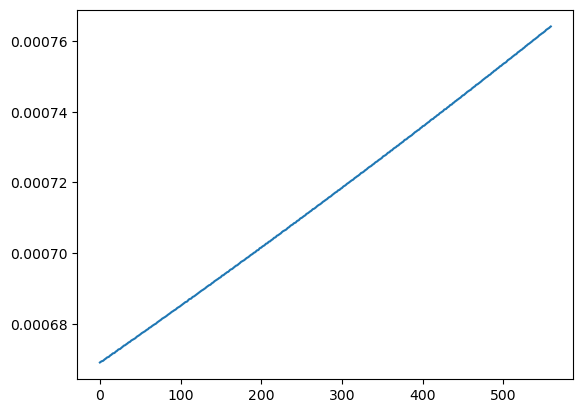

In [47]:
plt.plot(np.gradient(data['x1v']))

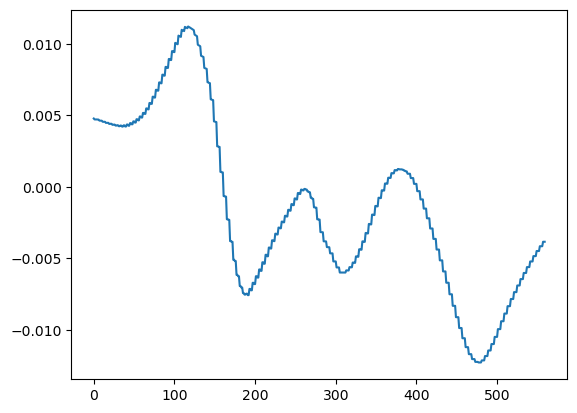

In [45]:
plt.plot(np.mean(np.mean(data['vel1'],axis=0), axis=0))

# Here I try to interpolate values

In [50]:
from scipy.spatial.distance import cdist
from scipy.interpolate import RegularGridInterpolator

In [52]:
import numpy as np
from scipy.spatial.distance import cdist

def trilinear_weights(x, y, z):
    """
    Compute the trilinear interpolation weights for a given point (x, y, z)
    relative to the 8 corners of a cube.

    Parameters:
        x (float): The x-coordinate of the point.
        y (float): The y-coordinate of the point.
        z (float): The z-coordinate of the point.

    Returns:
        weights (ndarray): A 1D array of length 8 containing the trilinear
            interpolation weights.
    """
    weights = np.zeros(8)
    weights[0] = (1 - x) * (1 - y) * (1 - z)
    weights[1] = x * (1 - y) * (1 - z)
    weights[2] = (1 - x) * y * (1 - z)
    weights[3] = x * y * (1 - z)
    weights[4] = (1 - x) * (1 - y) * z
    weights[5] = x * (1 - y) * z
    weights[6] = (1 - x) * y * z
    weights[7] = x * y * z
    return weights

def interpolate_velocities(vel_data, R_h, planet_loc):
    """
    Find the closest cell coordinates inside and outside the Hill's sphere
    and interpolate the velocity value on the surface of the Hill's sphere.

    Parameters:
        vel_data (ndarray): The velocity data array with shape (phi, theta, r).
        R_h (float): The Hill's radius.
        planet_loc (tuple): A tuple of the form (phi, theta, r) specifying the
            location of the planet in the velocity data array.

    Returns:
        inside_closest (tuple): A tuple of the form (phi, theta, r) specifying
            the coordinates of the closest cell inside the Hill's sphere.
        outside_closest (tuple): A tuple of the form (phi, theta, r) specifying
            the coordinates of the closest cell outside the Hill's sphere.
        vel_on_surface (float): The interpolated velocity value on the surface
            of the Hill's sphere.
    """
    # Get the cell size of the velocity data
    d_phi = 2 * np.pi / vel_data.shape[0]
    d_theta = np.pi / vel_data.shape[1]
    d_r = 1 / vel_data.shape[2]

    # Compute the coordinates of the centers of all cells in the velocity data
    phi_vals = np.linspace(0, 2*np.pi, vel_data.shape[0], endpoint=False) + d_phi / 2
    theta_vals = np.linspace(0, np.pi, vel_data.shape[1], endpoint=False) + d_theta / 2
    r_vals = np.linspace(0, 1, vel_data.shape[2], endpoint=False) + d_r / 2
    phi_centers, theta_centers, r_centers = np.meshgrid(phi_vals, theta_vals, r_vals, indexing='ij')

    # Convert the planet location to cell indices
    planet_idx = (int(planet_loc[0] / d_phi), int(planet_loc[1] / d_theta), int(planet_r / d_r))

    # Compute the distance of each cell center to the planet location
    dist_to_planet = cdist(np.array([(planet_loc[0], planet_loc[1], planet_loc[2])]), 
                        np.array([(phi_centers.flatten(), theta_centers.flatten(), r_centers.flatten())])).reshape(phi_centers.shape)

    # Find the closest cell coordinates inside and outside the Hill's sphere
    inside_mask = dist_to_planet <= R_h
    outside_mask = dist_to_planet > R_h
    inside_idxs = np.argwhere(inside_mask)
    outside_idxs = np.argwhere(outside_mask)
    inside_dists = dist_to_planet[inside_mask]
    outside_dists = dist_to_planet[outside_mask]
    inside_closest_idx = inside_idxs[np.argmin(inside_dists)]
    outside_closest_idx = outside_idxs[np.argmin(outside_dists)]
    inside_closest = (phi_centers[tuple(inside_closest_idx)], theta_centers[tuple(inside_closest_idx)], r_centers[tuple(inside_closest_idx)])
    outside_closest = (phi_centers[tuple(outside_closest_idx)], theta_centers[tuple(outside_closest_idx)], r_centers[tuple(outside_closest_idx)])

    # Compute the trilinear interpolation weights for the cell containing the planet
    x = (planet_loc[0] % d_phi) / d_phi
    y = (planet_loc[1] % d_theta) / d_theta
    z = (planet_loc[2] % d_r) / d_r
    weights = trilinear_weights(x, y, z)

    # Interpolate the velocity value on the surface of the Hill's sphere
    vel_on_surface = 0
    for i in range(8):
        vel_on_surface += weights[i] * vel_data[
            (inside_closest_idx[0] if weights[i] > 0.5 else outside_closest_idx[0]),
            (inside_closest_idx[1] if weights[i] > 0.5 else outside_closest_idx[1]),
            (inside_closest_idx[2] if weights[i] > 0.5 else outside_closest_idx[2])
        ]

    return inside_closest, outside_closest, vel_on_surface



In [75]:
def trilinear_weights(x, y, z):
    x, y, z = np.sort([x, y, z])
    w000 = (1 - x) * (1 - y) * (1 - z)
    w001 = (1 - x) * (1 - y) * z
    w010 = (1 - x) * y * (1 - z)
    w011 = (1 - x) * y * z
    w100 = x * (1 - y) * (1 - z)
    w101 = x * (1 - y) * z
    w110 = x * y * (1 - z)
    w111 = x * y * z
    return w000, w001, w010, w011, w100, w101, w110, w111

def interpolate_velocities(vel_data, planet_loc, R_h):
    phi = data['x3v']
    theta = data['x2v']
    r = data['x1v']

    # Compute cell center coordinates
    phi_centers, theta_centers, r_centers = np.meshgrid(phi, theta, r, indexing='ij')
    x_centers = r_centers * np.sin(theta_centers) * np.cos(phi_centers)
    y_centers = r_centers * np.sin(theta_centers) * np.sin(phi_centers)
    z_centers = r_centers * np.cos(theta_centers)

    # Compute distance from cell centers to planet location
    planet_loc = np.array(planet_loc).reshape((1, -1))
    print(np.column_stack((x_centers.ravel(), y_centers.ravel(), z_centers.ravel())).shape)
    dist = cdist(planet_loc, np.column_stack((x_centers.ravel(), y_centers.ravel(), z_centers.ravel())))
    dist = dist.reshape(vel_data.shape)

    # Create boolean masks for cells inside and outside Hill's sphere
    inside_mask = (dist <= R_h)
    outside_mask = (dist > R_h)

    # Find indices of closest cells to planet location inside and outside Hill's sphere
    inside_index = np.argwhere(inside_mask)
    inside_index = inside_index[np.argmin(dist[inside_mask])]
    outside_index = np.argwhere(outside_mask)
    outside_index = outside_index[np.argmin(dist[outside_mask])]

    # Compute coordinates of closest cells inside and outside Hill's sphere
    inside_coords = np.array([x_centers[inside_index[0], inside_index[1], inside_index[2]],
                            y_centers[inside_index[0], inside_index[1], inside_index[2]],
                            z_centers[inside_index[0], inside_index[1], inside_index[2]]])
    outside_coords = np.array([x_centers[outside_index[0], outside_index[1], outside_index[2]],
                            y_centers[outside_index[0], outside_index[1], outside_index[2]],
                            z_centers[outside_index[0], outside_index[1], outside_index[2]]])

    # Sort the input coordinates in ascending order
    phi, theta, r = np.sort([phi, theta, r], axis=1)

    # Create RegularGridInterpolator object
    interp_func = RegularGridInterpolator((phi, theta, r), vel_data)

    # Transpose velocity data to match interpolator input order
    vel_data = np.transpose(vel_data, (0, 1, 2))

    # Create interpolation function for velocity data
    interp_func = RegularGridInterpolator((phi, theta, r), vel_data)

    # Interpolate velocities at the two closest cells to the surface of Hill's sphere
    vel_inside = interp_func(inside_coords)
    vel_outside = interp_func(outside_coords)

    # Compute trilinear interpolation weights for point on surface of Hill's sphere
    weights = trilinear_weights(*np.abs(planet_loc - inside_coords) / R_h)

    # Interpolate velocity value at point on surface of Hill's sphere
    vel_on_surface = np.sum(np.array([vel_inside, vel_outside]) * weights)

    return inside_coords, outside_coords, vel_on_surface



In [76]:
# Define the parameters of the planet and star
a = 1.0   # semi-major axis of planet's orbit
m = 0.9e-3   # mass of planet
M = 1.0   # mass of star

# Define the radius of the Hill sphere
R_h = a * (m/(3*M))**(1/3)
planet_loc = (np.pi, np.pi/2, 1.0)
# planet_loc = np.reshape(planet_loc, (3, -1))

# Call the function
inside_closest, outside_closest, vel_on_surface = interpolate_velocities(data['vel1'], R_h, planet_loc)

: 

: 